## The Method

1. Prepare data & Partition the data into 80-20 train-test split
2. Define Models & Parameters
3. Perform Cross-Validation on the training data
3. (Re)Train the models on the training data, either vanilla model or with best hyperparameters
4. Evaluate the (re)trained models on the test data
5. Final evaluation of the models

![The Method](method.png)

Source: [scikit-learn.org - Cross-validation](https://scikit-learn.org/1.5/modules/cross_validation.html#cross-validation-and-model-selection)

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_validate
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as imblearn_pipeline # Use imblearn's pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.metrics import make_scorer, classification_report, precision_score, recall_score, f1_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import joblib
from scipy.stats import mannwhitneyu
from pprint import pprint
from time import time

from xgboost import XGBClassifier
from imbens.ensemble import SelfPacedEnsembleClassifier as SPEClassifier
from imblearn.over_sampling import RandomOverSampler

import warnings
warnings.filterwarnings('ignore')

RANDOM_STATE = 42
CROSS_VAL_SPLITS = 5


### 1. Prepare data & Partition the data into 80-20 train-test split

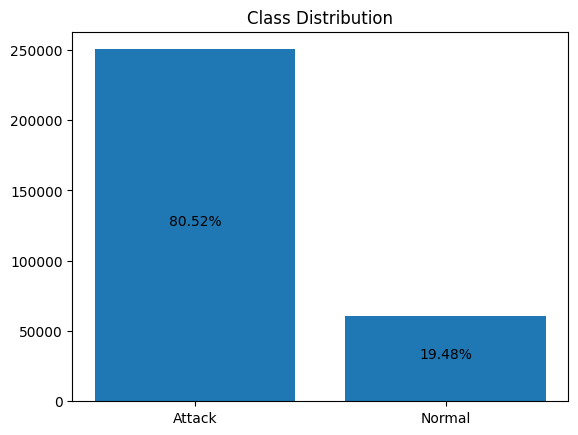

In [5]:
# Importing the dataset

path_to_data = '../data/kddcup/kddcup_data_corrected.csv'

# col names from https://kdd.ics.uci.edu/databases/kddcup99/kddcup.names
col_names = [
    "duration",
    "protocol_type",
    "service",
    "flag",
    "src_bytes",
    "dst_bytes",
    "land",
    "wrong_fragment",
    "urgent",
    "hot",
    "num_failed_logins",
    "logged_in",
    "num_compromised",
    "root_shell",
    "su_attempted",
    "num_root",
    "num_file_creations",
    "num_shells",
    "num_access_files",
    "num_outbound_cmds",
    "is_host_login",
    "is_guest_login",
    "count",
    "srv_count",
    "serror_rate",
    "srv_serror_rate",
    "rerror_rate",
    "srv_rerror_rate",
    "same_srv_rate",
    "diff_srv_rate",
    "srv_diff_host_rate",
    "dst_host_count",
    "dst_host_srv_count",
    "dst_host_same_srv_rate",
    "dst_host_diff_srv_rate",
    "dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate",
    "dst_host_serror_rate",
    "dst_host_srv_serror_rate",
    "dst_host_rerror_rate",
    "dst_host_srv_rerror_rate",
    "label",
]
# from https://kdd.ics.uci.edu/databases/kddcup99/kddcup.names
categorical_cols = [
    "protocol_type",
    "service",
    "flag",
    "land",
    "logged_in",
    "is_host_login",
    "is_guest_login",
]

# Read data (10 % subset of the original dataset)
data = pd.read_csv(path_to_data, names=col_names, header=None)

# summarize attack types as "attack" for binary classification
data["label"] = data["label"].apply(lambda x: "attack" if x != "normal." else 'normal')

# Split data sets into X, y respectively
X = data.drop("label", axis=1)
y = data["label"]

# Visualize class imbalance
plt.bar(["Attack", "Normal"], data["label"].value_counts())
total = len(data)
fraud_percentage = (data["label"].value_counts()[1] / total) * 100
normal_percentage = (data["label"].value_counts()[0] / total) * 100

plt.text(0, data["label"].value_counts()[0] / 2, f'{normal_percentage:.2f}%', ha='center', color='black')
plt.text(1, data["label"].value_counts()[1] / 2, f'{fraud_percentage:.2f}%', ha='center', color='black')
plt.title("Class Distribution")
plt.show()

data.label.value_counts()

# define numerical cols
num_cols = data.drop(categorical_cols, axis=1)

# Preprocessing pipeline for categorical and numerical data
preprocessor = ColumnTransformer(
	transformers=[
		('num', StandardScaler(), num_cols.drop('label', axis=1).columns),
		('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False, dtype="int8") # bool/int8 saves 2.66x RAM vs int64
   				 ,categorical_cols)
	]
)

# Encode labels (LabelEncoder is not part of the pipeline but applied directly to y)
le = LabelEncoder()
y = le.fit_transform(y)

# create training and test partitions with 80-20 split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y)

### 2. Define models and parameters

In [6]:
# Vanilla XGBoost
vanilla_xgb_pipeline = Pipeline(
    [
        ("preprocessor", preprocessor),
        ("xgb", XGBClassifier()),  # Default XGBoost classifier
    ]
)

# RandomizedSearchCV XGBoost
random_search_xgb_pipeline = Pipeline(
    [
        ("preprocessor", preprocessor),
        ("rs_tuned_xgb", XGBClassifier()),  # XGBoost as base estimator
    ]
)

# RandomOverSampling Pipeline
ros_xgb_pipeline = imblearn_pipeline(
    [
        ("preprocessor", preprocessor),
        (
            "ros",
            RandomOverSampler(random_state=RANDOM_STATE, sampling_strategy=1),
        ),  # 1:1 ratio
        ("xgb_randover", XGBClassifier()),  # XGBoost as base estimator
    ]
)

# SPE boosted XGBoost
spe_boosted_xgb_pipeline = Pipeline(
    [
        ("preprocessor", preprocessor),
        (
            "spe_xgb",
            SPEClassifier(estimator=XGBClassifier()),
        ),  # XGBoost as base estimator
    ]
)

# 10-fold cross-validation setup
cv = StratifiedKFold(n_splits=10)

parameter_grid = {
    # general params
    "rs_tuned_xgb__objective": [
        "binary:logistic"
    ],  # logistic regression for binary classification, output probability
    # tree booster params
    "rs_tuned_xgb__max_leaves": [0, 2**6, 2**8],  # default 0
    "rs_tuned_xgb__learning_rate": [0.002, 0.1, 0.3],  # alias: eta, step size
    "rs_tuned_xgb__gamma": [0.1, 0.3],  # min loss reduction to create new tree split
    "rs_tuned_xgb__max_depth": [6, 12, 20, 25],  # max depth of tree
    "rs_tuned_xgb__subsample": [0.4, 0.7, 1],
    "rs_tuned_xgb__colsample_bytree": [
        0.4,
        0.5,
        0.7,
        1,
    ],  # subsample ratio of columns when constructing each tree
    "rs_tuned_xgb__reg_alpha": [
        0,
        0.9,
        1,
    ],  # l1 regularization term on weights, default = 0
    "rs_tuned_xgb__reg_lambda": [
        0.3,
        1,
    ],  # l2 regularization term on weights, default = 1
    "rs_tuned_xgb__scale_pos_weight": [
        1,
        2,
        4,
        580,
    ],  # control balance of positive and negative weights, useful for unbalanced classes. recommended to start with sum(negative instances) / sum(positive instances)
    "rs_tuned_xgb__n_estimators": [100, 170, 500, 700, 1000, 2000, 5000],
    "rs_tuned_xgb__eval_metric": ["aucpr"],
    "rs_tuned_xgb__booster": ["gbtree"],
    "rs_tuned_xgb__tree_method": ["hist"],
}

# Define multimetric scoring
scoring = {
    "f1": make_scorer(f1_score),
    "precision": make_scorer(precision_score),
    "recall": make_scorer(recall_score),
}

# Randomized search with k-fold cross-validation
random_search = RandomizedSearchCV(
    estimator=random_search_xgb_pipeline,
    param_distributions=parameter_grid,
    n_iter=10,
    scoring=scoring,  # Multimetric scoring
    refit="f1",  # Refit on F1 score. Other metrics are for reporting purposes. F1 will be used to select the best model.
    cv=StratifiedKFold(n_splits=CROSS_VAL_SPLITS),  # k-fold stratified cross-validation
    verbose=1,
    n_jobs=-1,  # Use all available cores
    random_state=RANDOM_STATE,
)

### 3. Perform Cross-Validation on the training data

In [9]:
load_from_saved = True

if (load_from_saved == False):
    # Run random search on XGBoost and fit to training data
    print("\nRunning RandomizedSearchCV for XGBoost...")
    print("Hyperparameters to be evaluated:\n")
    pprint(parameter_grid)

    t0 = time()
    random_search.fit(X_train, y_train)
    print(f"\nRandomizedSearchCV took {time() - t0:.2f} seconds ({(time() - t0) / 60:.2f} minutes)")

    print("\nBest parameters combination found:")
    best_parameters = random_search.best_estimator_.get_params()
    for param_name in sorted(parameter_grid.keys()):
        print(f"{param_name}: {best_parameters[param_name]}")

    # Best estimator from RandomizedSearchCV
    best_xgb_model = random_search.best_estimator_

    # save model
    joblib.dump(best_xgb_model, 'saved/KDD_best_xgb_model.pkl')
else:
    best_xgb_model = joblib.load('saved/KDD_best_xgb_model.pkl')
    display(best_xgb_model)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  Index(['duration', 'src_bytes', 'dst_bytes', 'wrong_fragment', 'urgent', 'hot',
       'num_failed_logins', 'num_compromised', 'root_shell', 'su_attempted',
       'num_root', 'num_file_creations', 'num_shells', 'num_access_files',
       'num_outbound_cmds', 'count', 'srv_count', 'serror_rate',
       'srv...
                               feature_types=None, gamma=0.3, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.3,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=6, max_leaves=64,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=2000, n_jobs=None,
                               num_parallel_tree=None, random_state=None, ...))])

In [12]:
# Get the index of the best combination found by RandomizedSearchCV
best_index = random_search.best_index_

# Extract mean and std for each metric from the best estimator
f1_mean = random_search.cv_results_['mean_test_f1'][best_index]
f1_std = random_search.cv_results_['std_test_f1'][best_index]

precision_mean = random_search.cv_results_['mean_test_precision'][best_index]
precision_std = random_search.cv_results_['std_test_precision'][best_index]

recall_mean = random_search.cv_results_['mean_test_recall'][best_index]
recall_std = random_search.cv_results_['std_test_recall'][best_index]

# Display results with mean ± std deviation format
print("\nCross-Validation Results:")
print(f"F1 Score: {f1_mean:.4f} ± {f1_std:.4f}")
print(f"Precision: {precision_mean:.4f} ± {precision_std:.4f}")
print(f"Recall: {recall_mean:.4f} ± {recall_std:.4f}")


Cross-Validation Results:
F1 Score: 0.9502 ± 0.0016
Precision: 0.9503 ± 0.0026
Recall: 0.9501 ± 0.0028


In [13]:
# 5-fold cross-validation for Vanilla XGBoost
print(f"{CROSS_VAL_SPLITS}-fold cross-validation for vanilla XGBoost:")

vanilla_xgb_scores = cross_validate(
    vanilla_xgb_pipeline, X_train, y_train, 
    cv=StratifiedKFold(n_splits=CROSS_VAL_SPLITS), scoring=scoring, n_jobs=-1
)
vanilla_xgb_scores_df = pd.DataFrame(vanilla_xgb_scores)

# Print mean ± standard deviation of scores
print("\nVanilla XGBoost:")
for metric in scoring.keys():
    mean_score = vanilla_xgb_scores_df[f'test_{metric}'].mean()
    std_score = vanilla_xgb_scores_df[f'test_{metric}'].std()
    print(f"{metric}: {mean_score:.4f} ± {std_score:.4f}")


# 5-fold cross-validation for Self-paced ensemble classifier
print(f"\n{CROSS_VAL_SPLITS}-fold cross-validation for Vanilla SPE XGBoost:")

spe_boosted_xgb_scores = cross_validate(
    spe_boosted_xgb_pipeline, X_train, y_train, 
    cv=StratifiedKFold(n_splits=CROSS_VAL_SPLITS), scoring=scoring, n_jobs=-1
)
spe_boosted_xgb_scores_df = pd.DataFrame(spe_boosted_xgb_scores)

print("\nSelf-paced ensemble classifier:")
for metric in scoring.keys():
    mean_score = spe_boosted_xgb_scores_df[f'test_{metric}'].mean()
    std_score = spe_boosted_xgb_scores_df[f'test_{metric}'].std()
    print(f"{metric}: {mean_score:.4f} ± {std_score:.4f}")

5-fold cross-validation for vanilla XGBoost:

Vanilla XGBoost:
f1: 0.9500 ± 0.0017
precision: 0.9507 ± 0.0017
recall: 0.9494 ± 0.0029

5-fold cross-validation for Vanilla SPE XGBoost:

Self-paced ensemble classifier:
f1: 0.9346 ± 0.0028
precision: 0.9982 ± 0.0007
recall: 0.8787 ± 0.0046


In [4]:
# 5-fold cross-validation for RandOver XGBoost
print(f"{CROSS_VAL_SPLITS}-fold cross-validation for RandOver XGBoost:")

randover_xgb_scores = cross_validate(
    ros_xgb_pipeline, X_train, y_train, 
    cv=StratifiedKFold(n_splits=CROSS_VAL_SPLITS), scoring=scoring, n_jobs=-1
)
randover_xgb_scores_df = pd.DataFrame(randover_xgb_scores)

# Print mean ± standard deviation of scores
print("\nRandOver XGBoost:")
for metric in scoring.keys():
    mean_score = randover_xgb_scores_df[f'test_{metric}'].mean()
    std_score = randover_xgb_scores_df[f'test_{metric}'].std()
    print(f"{metric}: {mean_score:.4f} ± {std_score:.4f}")

5-fold cross-validation for RandOver XGBoost:

RandOver XGBoost:
f1: 0.9422 ± 0.0019
precision: 0.8923 ± 0.0036
recall: 0.9980 ± 0.0005


### 4. (Re)Train the models on the training data, either vanilla model or with best hyperparameters

In [10]:
# train vanilla xgb
vanilla_xgb_pipeline.fit(X_train, y_train)

# train spe xgb
spe_boosted_xgb_pipeline.fit(X_train, y_train)

# retrain best xgb model on full training set
best_xgb_model.fit(X_train, y_train)

# retrain randover xgb
ros_xgb_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  Index(['duration', 'src_bytes', 'dst_bytes', 'wrong_fragment', 'urgent', 'hot',
       'num_failed_logins', 'num_compromised', 'root_shell', 'su_attempted',
       'num_root', 'num_file_creations', 'num_shells', 'num_access_files',
       'num_outbound_cmds', 'count', 'srv_count', 'serror_rate',
       'srv...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=None, ...))])

### 5. Final evaluation of the models

Vanilla XGBoost
F-1 Score: 0.9509
Precision: 0.9532
Recall: 0.9485

SPE XGBoost
F-1 Score: 0.9318
Precision: 0.9976
Recall: 0.8742

Best XGBoost (RandomSearchCV)
F-1 Score: 0.9475
Precision: 0.9608
Recall: 0.9346

RandOver XGB
F-1 Score: 0.9420
Precision: 0.8917
Recall: 0.9983


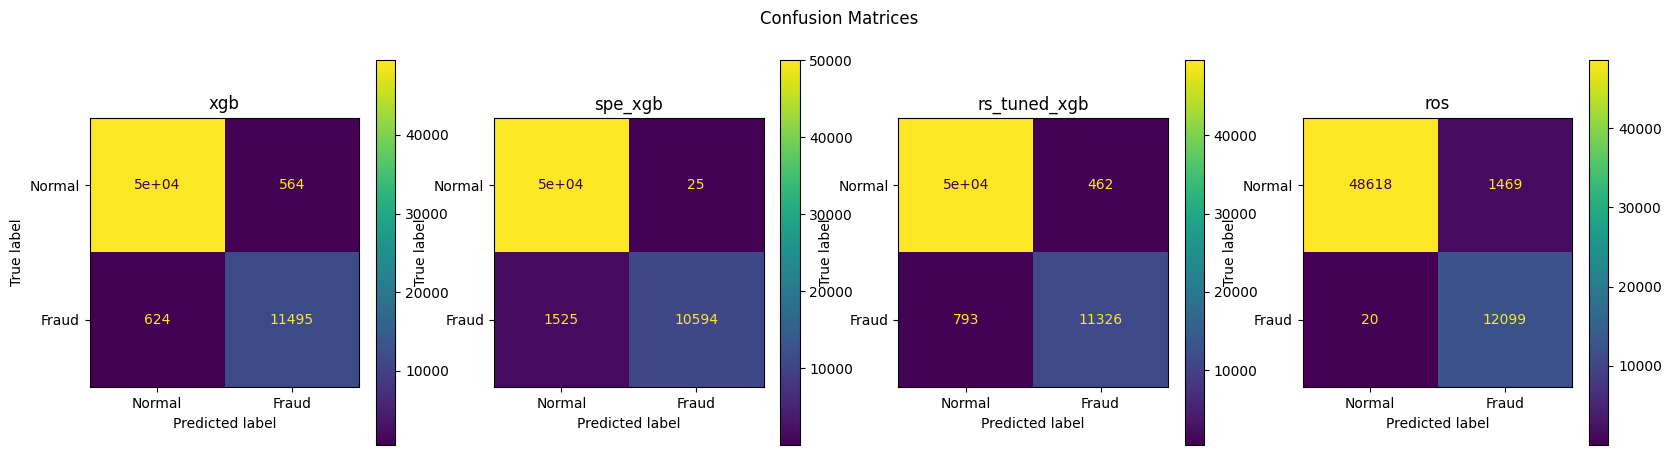

In [11]:
# evaluate each model on test set on f1, prec, recall and plot confusion matrix for each

# Vanilla XGBoost
y_test_pred = vanilla_xgb_pipeline.predict(X_test)
print("Vanilla XGBoost")
print(f"F-1 Score: {f1_score(y_test, y_test_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_test_pred):.4f}")
print(f"Recall: {recall_score(y_test, y_test_pred):.4f}")

# SPE XGBoost
y_test_pred = spe_boosted_xgb_pipeline.predict(X_test)
print("\nSPE XGBoost")
print(f"F-1 Score: {f1_score(y_test, y_test_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_test_pred):.4f}")
print(f"Recall: {recall_score(y_test, y_test_pred):.4f}")

# Best XGBoost
y_test_pred = best_xgb_model.predict(X_test)
print("\nBest XGBoost (RandomSearchCV)")
print(f"F-1 Score: {f1_score(y_test, y_test_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_test_pred):.4f}")
print(f"Recall: {recall_score(y_test, y_test_pred):.4f}")

# RandOver XGB
y_test_pred = ros_xgb_pipeline.predict(X_test)
print("\nRandOver XGB")
print(f"F-1 Score: {f1_score(y_test, y_test_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_test_pred):.4f}")
print(f"Recall: {recall_score(y_test, y_test_pred):.4f}")

# Plot confusion matrix for each model
fig, axs = plt.subplots(1, 4, figsize=(20, 5))
fig.suptitle("Confusion Matrices")
for i, model in enumerate([vanilla_xgb_pipeline, spe_boosted_xgb_pipeline, best_xgb_model, ros_xgb_pipeline]):
	y_test_pred = model.predict(X_test)
	cm = confusion_matrix(y_test, y_test_pred)
	disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal", "Fraud"])
	disp.plot(ax=axs[i])
	axs[i].set_title(model.steps[1][0])
	
plt.show()
